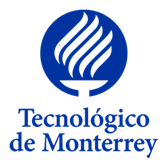

## Proyecto Integrador
## Smart Travel Assistant: Optimizando la Experiencia de Viaje con IA
## Avance 2

### Equipo 37
##### A00759664 - Joel Orlando Hernández Ramos
##### A01793486 - Juan Carlos Alvarado Carricarte
##### A00260430 - Juan Carlos Romo Cárdenas


## **Descripción del Proyecto**

Este proyecto se propone desarrollar un asistente de inteligencia artificial integrado en una plataforma de traveltech, que facilita la elección personalizada de hoteles y destinos para los usuarios. Utilizando la función "knowledge base" de Amazon Bedrock, el sistema integrará una extensa base de datos con información detallada sobre más de 2 millones de hoteles. Para este efecto  

El objetivo principal de este proyecto es transformar la experiencia de planificación de viajes, haciendo que sea más intuitiva, personalizada y respaldada por datos. Las metas específicas incluyen mejorar la satisfacción del cliente mediante recomendaciones precisas y personalizadas, reducir el tiempo necesario para planificar un viaje y aumentar la eficiencia del proceso de selección de destinos y hoteles.

El asistente empleará modelos avanzados de sistemas de recomendación, potenciados por un modelo de lenguaje de aprendizaje profundo (LLM), para sugerir itinerarios personalizados y ofrecer asistencia general en la planificación de viajes. Las recomendaciones incluirán referencias detalladas a los hoteles disponibles en nuestra base de datos, asegurando que los usuarios reciban opciones que no solo se ajustan a sus preferencias personales, sino que también maximizan la calidad y la relevancia de la información proporcionada.

## **Cargando Conjunto de Datos**

In [1]:
# Importando librerias requeridas
import re
import json
import uuid
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import seaborn as sns


In [2]:
DATA_SET = '../hotel-dataset'
DATA_SOURCE = '../hotel-data-source'

In [3]:
# Cargando conjunto de datos de hoteles como un Dataset multi-parte de Apache Parquet
dataset = pq.ParquetDataset(DATA_SET)
table = dataset.read()

In [4]:
# Creando un Dataframe de Pandas para el analisis
dataframe = table.to_pandas()


In [5]:
#Corroboramos el tamaño de nuestro DataFrame para tenerlo como referencia.
dataframe.shape

(1093095, 14)

## **Limpieza y Preparación de los Datos**

Hasta el momento, solamente se conoce que se cuenta con un conjunto de datos con más de 1,093,000 entradas y 14 dimensiones o columnas.


Las columnas incluyen valores como la descripción del hotel, el número de estrellas del hotel, la dirección del hotel, el código del país donde se localiza el hotel y sus coordenadas geográficas, entre otras.

Para crear la base de conocimientos en AWS Bedrock, preliminarmente, se esperan usar los siguientes campos o columnas:
* Nombre del hotel
* Descripción del hotel
* Nombre de la ciudad donde se ubica el hotel
* Código del país donde se ubica el hotel
* Nivel del hotel (rating)

Otras piezas de información que se podrían usar incluyen:
* Longitud y Latitud

La decisión final dependerá del análisis que se realice en este entregable.


In [6]:
dataframe = dataframe.drop(['uuid','match_id','match_confidence_score'], axis=1)

Uno de los parámetros importantes para crear una base de conocimiento para RAG es el tamaño del texto en caracteres, o ***chunk size***. Para este efecto, se agregará una nueva columna con el tamaño de la descripción del hotel en caracteres.

In [7]:
# Calculando el tamaño en caracteres de la descripción del hotel
dataframe['DescLength'] = dataframe['Description'].str.len()


In [8]:
dataframe.describe(include='all')

,HotelCode,HotelName,Description,Address,Pincode,CountryCode,PhoneNumber,CityName,Longitude,Latitude,HotelRating,DescLength
count,1093095,1093095,1093095,1093095,1093095,1093095,742223,1093095,1090879,1093095,1.093052e+06,1.093095e+06
unique,1093095,994885,1025518,1060951,178491,441,612681,100184,1009164,980655,NaN,NaN
top,1688289,quality inn,<br/><b>Disclaimer notification: Amenities are...,"510 gulf shore drive, , destin, 32541, usa",,US,91-93-13931393,Rome,-86.49782,,NaN,NaN
freq,1,373,62806,94,40804,116324,6690,7937,94,2217,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.772850e+01,1.356845e+03
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.784483e+04,5.874179e+02
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,9.770000e+02
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000e+00,1.383000e+03
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000e+00,1.750000e+03



La descripción extendida de los datos almacenados en el conjunto de datos indica que:

* Hay 1,093,095 registros con 14 columnas.
* Las columnas PhoneNumber y Longitude tienen valores ausentes.
* El nivel promedio de estrellas de los hoteles es por encima de 4 estrellas, de acuerdo a la media de HotelRating.
* El tamaño promedio en caracteres de la descripción de un hotel es 1,356, de acuerdo a la media de DescLength, aunque hay descripciones vacías basadas en el valor mínimo de cero (0) de la misma columna.


### **Reemplazo de Datos Incorrectos y Faltantes**

Un hallazgo importante de la fase anterior es que, en los registros donde el valor de longitud no está presente, la latitud tampoco presenta un valor, aun cuando el análisis de valores ausentes indica que cuenta con valores para todos los registros.

Se convertirán los valores de longitud y latitud a un valor de punto flotante válido o faltante.

In [9]:
# Convirtiendo latitud y longitud a un número
def to_float_number(x):
    try:
        return float(x)
    except:
        return np.nan

dataframe['Longitude'] = dataframe['Longitude'].apply(to_float_number)
dataframe['Latitude'] = dataframe['Latitude'].apply(to_float_number)

In [10]:
# Actualizando datos faltantes para los teléfonos
def fill_phone_number(x):
    if x == None:
        return 'N/A'
    else:
        return x


dataframe['PhoneNumber'] = dataframe['PhoneNumber'].apply(fill_phone_number)

In [11]:
# Registro con un nivel de estrellas mayor a 5
dataframe.loc[826365]

HotelCode                                                1883789
HotelName                                    malvina house hotel
Description    Malvina House Hotel has a garden, shared loung...
Address        ross road 3, stanley, stanley, fiqq 1zz, falkl...
Pincode                                                 FIQQ 1ZZ
CountryCode                                                   FK
PhoneNumber                                   +50021355+50021360
CityName                                                 Stanley
Longitude                                              -51.69174
Latitude                                                     0.0
HotelRating                                           50021357.0
DescLength                                                   608
Name: 826365, dtype: object

In [12]:
# Cambiando valor de nivel de estrellas para el hotel con un valor mayor a 5
dataframe.loc[826365, 'HotelRating']= 4.5

In [13]:
# Convirtiendo CountryCode a mayusculas
def to_capital_letters(x):
    try:
        return str(x).upper()
    except:
        return np.nan

dataframe['CountryCode'] = dataframe['CountryCode'].apply(to_capital_letters)

In [14]:
# Registro con código de país faltante
dataframe.loc[28426]

HotelCode                                                5005278
HotelName                                       zone connect goa
Description    <br/><b>Disclaimer notification: Amenities are...
Address        569/1-a, carrasco vaddo, ?parra, bardez, 40351...
Pincode                                                         
CountryCode                                                     
PhoneNumber                                                  N/A
CityName                                                  Anjuna
Longitude                                               73.78512
Latitude                                                15.56537
HotelRating                                                  4.0
DescLength                                                   121
Name: 28426, dtype: object

In [15]:
# Registro con código de país faltante
dataframe.loc[903509]

HotelCode                                                5007841
HotelName                                  frankfort hotel & spa
Description    <br/><b>Disclaimer notification: Amenities are...
Address        ??. mar, 4, 100164 tashkent, uzbekistan, , tas...
Pincode                                                         
CountryCode                                                     
PhoneNumber                                                  N/A
CityName                                                Tashkent
Longitude                                              69.328835
Latitude                                               41.345065
HotelRating                                                  3.0
DescLength                                                   121
Name: 903509, dtype: object

In [16]:
# Registro con código de país faltante
dataframe.loc[907683]

HotelCode                                                5017661
HotelName                                     reyado hotel kudan
Description    Property Description\nOpened: 2019Number of Ro...
Address        2-4-10 kudan minami, chiyoda-ku, chiyoda, toky...
Pincode                                                  1020074
CountryCode                                                     
PhoneNumber                                         03-6869-0601
CityName                                                   Tokyo
Longitude                                             139.744092
Latitude                                               35.693256
HotelRating                                                  0.0
DescLength                                                   446
Name: 907683, dtype: object

In [17]:
# Registro con código de país faltante
dataframe.loc[931385]

HotelCode                                                5021855
HotelName                   ramada wyndham huangshi huangshigang
Description    <p>The best of the area is within easy reach w...
Address        32 yingbin avenue, huangshi port district, hua...
Pincode                                                   435000
CountryCode                                                     
PhoneNumber                                                  N/A
CityName                                                Huangshi
Longitude                                             115.042888
Latitude                                               30.245982
HotelRating                                                  0.0
DescLength                                                   655
Name: 931385, dtype: object

In [18]:
# Asignando códigos de país faltantes
dataframe.loc[28426, 'CountryCode'] = 'IN'
dataframe.loc[903509, 'CountryCode'] = 'UZ'
dataframe.loc[907683, 'CountryCode'] = 'JP'
dataframe.loc[931385, 'CountryCode'] = 'CN'

In [19]:
# Registro con código de país numérico
dataframe.loc[226508]

HotelCode                                                5022122
HotelName                                hypernym hotel & suites
Description    <p>HeadLine : Near Tivoli Gardens</p><p>Locati...
Address        studiestræde 61,, 1554 copenhagen, denmark, de...
Pincode                                                     1554
CountryCode                                                   11
PhoneNumber                                            1-5555555
CityName                                                 Denmark
Longitude                                              12.565302
Latitude                                               55.676868
HotelRating                                                  3.0
DescLength                                                  1651
Name: 226508, dtype: object

In [20]:
# Registro con código de país numérico
dataframe.loc[564401]

HotelCode                                                5012156
HotelName                                        tier collection
Description    <p>HeadLine : In Athens (Athens City Centre)</...
Address        viktoros ougko, athens, athens, 104 37, athens...
Pincode                                                   104 37
CountryCode                                                   11
PhoneNumber                                        30-6987169735
CityName                                                  Athens
Longitude                                              23.722661
Latitude                                               37.986424
HotelRating                                                  3.0
DescLength                                                  1630
Name: 564401, dtype: object

In [21]:
# Registro con código de país numérico
dataframe.loc[292980]

HotelCode                                                5007255
HotelName                                    garden square hotel
Description    <p>HeadLine : In Kraków (Lagiewniki)</p><p>Loc...
Address        1d sucha,, krakow, malopolskie, 30-601, krakow...
Pincode                                                   30-601
CountryCode                                                   12
PhoneNumber                                         48-533398849
CityName                                                  Krakow
Longitude                                              19.934406
Latitude                                               50.023739
HotelRating                                                  4.0
DescLength                                                  1929
Name: 292980, dtype: object

In [22]:
# Registro con código de país numérico
dataframe.loc[755576]

HotelCode                                                5015037
HotelName                          yogved hospitality and resort
Description    Set in Rishikesh, 30 km from Mansa Devi Temple...
Address        bhumi khata no. 7 & 9 , ghuyhtiyni talli , dev...
Pincode                                                   249001
CountryCode                                                   13
PhoneNumber                                                  N/A
CityName                                               Rishikesh
Longitude                                               78.32642
Latitude                                                30.13094
HotelRating                                                  3.0
DescLength                                                  1038
Name: 755576, dtype: object

In [23]:
# Registro con código de país numérico
dataframe.loc[905058]

HotelCode                                                5011361
HotelName                                     number 4 apartment
Description    A 10-minute walk from Naiharn Beach, Number 4 ...
Address        14/100 moo 1, soi saiyuan, saiyuan rd, muang, ...
Pincode                                                    83130
CountryCode                                                   13
PhoneNumber                                                  N/A
CityName                                                  Phuket
Longitude                                               98.31422
Latitude                                                 7.78167
HotelRating                                                  2.0
DescLength                                                  1790
Name: 905058, dtype: object

In [24]:
# Registro con código de país numérico
dataframe.loc[901282]

HotelCode                                                6193930
HotelName                              labranda miraluna village
Description    <p>HeadLine : Near Kardamis Beach</p><p>Locati...
Address              kiotari, , lindos beach villa kiotari, null
Pincode                                                     null
CountryCode                                                   85
PhoneNumber                                       30-22440-47371
CityName                              Lindos Beach Villa Kiotari
Longitude                                              27.987262
Latitude                                               36.063139
HotelRating                                                  4.0
DescLength                                                  2119
Name: 901282, dtype: object

In [25]:
# Corrigiendo registros con códigos de país numéricos
dataframe.loc[226508, 'CountryCode'] = 'DK'
dataframe.loc[564401, 'CountryCode'] = 'GR'
dataframe.loc[292980, 'CountryCode'] = 'PL'
dataframe.loc[755576, 'CountryCode'] = 'IN'
dataframe.loc[905058, 'CountryCode'] = 'TH'
dataframe.loc[901282, 'CountryCode'] = 'GR'

In [26]:
# Verificando que la descripción sea de tipo "string#
def get_type(text):
    if type(text) is str:
        return 'str'
    else:
        return 'non-str'
dataframe['DescType'] = 'N/A'
dataframe['DescType'] = dataframe['Description'].apply(get_type)

In [27]:
dataframe.loc[dataframe['DescType'] != "str"]

,HotelCode,HotelName,Description,Address,Pincode,CountryCode,PhoneNumber,CityName,Longitude,Latitude,HotelRating,DescLength,DescType


In [28]:
# Función para remover elementos de HTML de un texto 
def remove_html_tags(text):
    html_pattern = re.compile('<.*?>')
    clean_text = re.sub(html_pattern, '', text)
    return clean_text

In [29]:
# Removiendo elementos de HTML de la descripción de los hoteles
dataframe['Description'] = dataframe['Description'].apply(remove_html_tags)

In [30]:
dataframe.describe(include='all')

,HotelCode,HotelName,Description,Address,Pincode,CountryCode,PhoneNumber,CityName,Longitude,Latitude,HotelRating,DescLength,DescType
count,1093095,1093095,1093095,1093095,1093095,1093095,1093095,1093095,1.066303e+06,1.066296e+06,1.093052e+06,1.093095e+06,1093095
unique,1093095,994885,1025512,1060951,178491,237,612681,100184,NaN,NaN,NaN,NaN,1
top,1688289,quality inn,Disclaimer notification: Amenities are subject...,"510 gulf shore drive, , destin, 32541, usa",,US,N/A,Rome,NaN,NaN,NaN,NaN,str
freq,1,373,62806,94,40804,117794,350874,7937,NaN,NaN,NaN,NaN,1093095
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.140530e+02,-2.020943e+02,1.965489e+00,1.356845e+03,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.054447e+05,2.401704e+05,1.527185e+00,5.874179e+02,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.800000e+02,-2.480038e+08,0.000000e+00,0.000000e+00,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.599182e+00,2.197788e+01,0.000000e+00,9.770000e+02,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.246621e+01,3.904455e+01,2.000000e+00,1.383000e+03,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.487324e+01,4.581208e+01,3.000000e+00,1.750000e+03,NaN


In [31]:
dataframe.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1093095 entries, 0 to 1093094
Data columns (total 13 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   HotelCode    1093095 non-null  object 
 1   HotelName    1093095 non-null  object 
 2   Description  1093095 non-null  object 
 3   Address      1093095 non-null  object 
 4   Pincode      1093095 non-null  object 
 5   CountryCode  1093095 non-null  object 
 6   PhoneNumber  1093095 non-null  object 
 7   CityName     1093095 non-null  object 
 8   Longitude    1066303 non-null  float64
 9   Latitude     1066296 non-null  float64
 10  HotelRating  1093052 non-null  float64
 11  DescLength   1093095 non-null  int64  
 12  DescType     1093095 non-null  object 
dtypes: float64(3), int64(1), object(9)
memory usage: 108.4+ MB


### **Limpieza de Datos Incorrectos**

In [32]:
# Removiendo registros con descripciones de menos de 121 caracteres
dataframe = dataframe.loc[dataframe['DescLength']>121]

In [33]:
dataframe.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 1030184 entries, 0 to 1093094
Data columns (total 13 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   HotelCode    1030184 non-null  object 
 1   HotelName    1030184 non-null  object 
 2   Description  1030184 non-null  object 
 3   Address      1030184 non-null  object 
 4   Pincode      1030184 non-null  object 
 5   CountryCode  1030184 non-null  object 
 6   PhoneNumber  1030184 non-null  object 
 7   CityName     1030184 non-null  object 
 8   Longitude    1003707 non-null  float64
 9   Latitude     1003701 non-null  float64
 10  HotelRating  1030142 non-null  float64
 11  DescLength   1030184 non-null  int64  
 12  DescType     1030184 non-null  object 
dtypes: float64(3), int64(1), object(9)
memory usage: 110.0+ MB


### **Limpieza de Datos Faltantes**

In [34]:
# Determinando columnas con valores ausentes
dataframe.isnull().sum()

HotelCode          0
HotelName          0
Description        0
Address            0
Pincode            0
CountryCode        0
PhoneNumber        0
CityName           0
Longitude      26477
Latitude       26483
HotelRating       42
DescLength         0
DescType           0
dtype: int64

In [35]:
# Eliminado registros con datos faltantes
dataframe = dataframe.dropna()

In [36]:
dataframe.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 1003665 entries, 0 to 1093094
Data columns (total 13 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   HotelCode    1003665 non-null  object 
 1   HotelName    1003665 non-null  object 
 2   Description  1003665 non-null  object 
 3   Address      1003665 non-null  object 
 4   Pincode      1003665 non-null  object 
 5   CountryCode  1003665 non-null  object 
 6   PhoneNumber  1003665 non-null  object 
 7   CityName     1003665 non-null  object 
 8   Longitude    1003665 non-null  float64
 9   Latitude     1003665 non-null  float64
 10  HotelRating  1003665 non-null  float64
 11  DescLength   1003665 non-null  int64  
 12  DescType     1003665 non-null  object 
dtypes: float64(3), int64(1), object(9)
memory usage: 107.2+ MB


In [37]:
# Verificando que no hay columnas con valores ausentes
dataframe.isnull().sum()

HotelCode      0
HotelName      0
Description    0
Address        0
Pincode        0
CountryCode    0
PhoneNumber    0
CityName       0
Longitude      0
Latitude       0
HotelRating    0
DescLength     0
DescType       0
dtype: int64


Después de arreglar los datos incorrectos, remover registros con descripciones incorrectas y eliminado datos faltantes se obtuvo una nueva cuenta de registros de **1,003,665**, o una reducción del **8.2%** en la cantidad de registros.



## **Análisis de la Distribución de los Datos**

Dado que se redujo el número de registros es importante verificar que la distribución de los datos no se vio afectada severamente.

In [38]:
# Creando una tabla de pivoteo para verificar la distribución de hoteles por país
pivot_table = pd.pivot_table(data=dataframe,index=['CountryCode'],values=['HotelRating'],aggfunc='count')

<Axes: xlabel='CountryCode'>

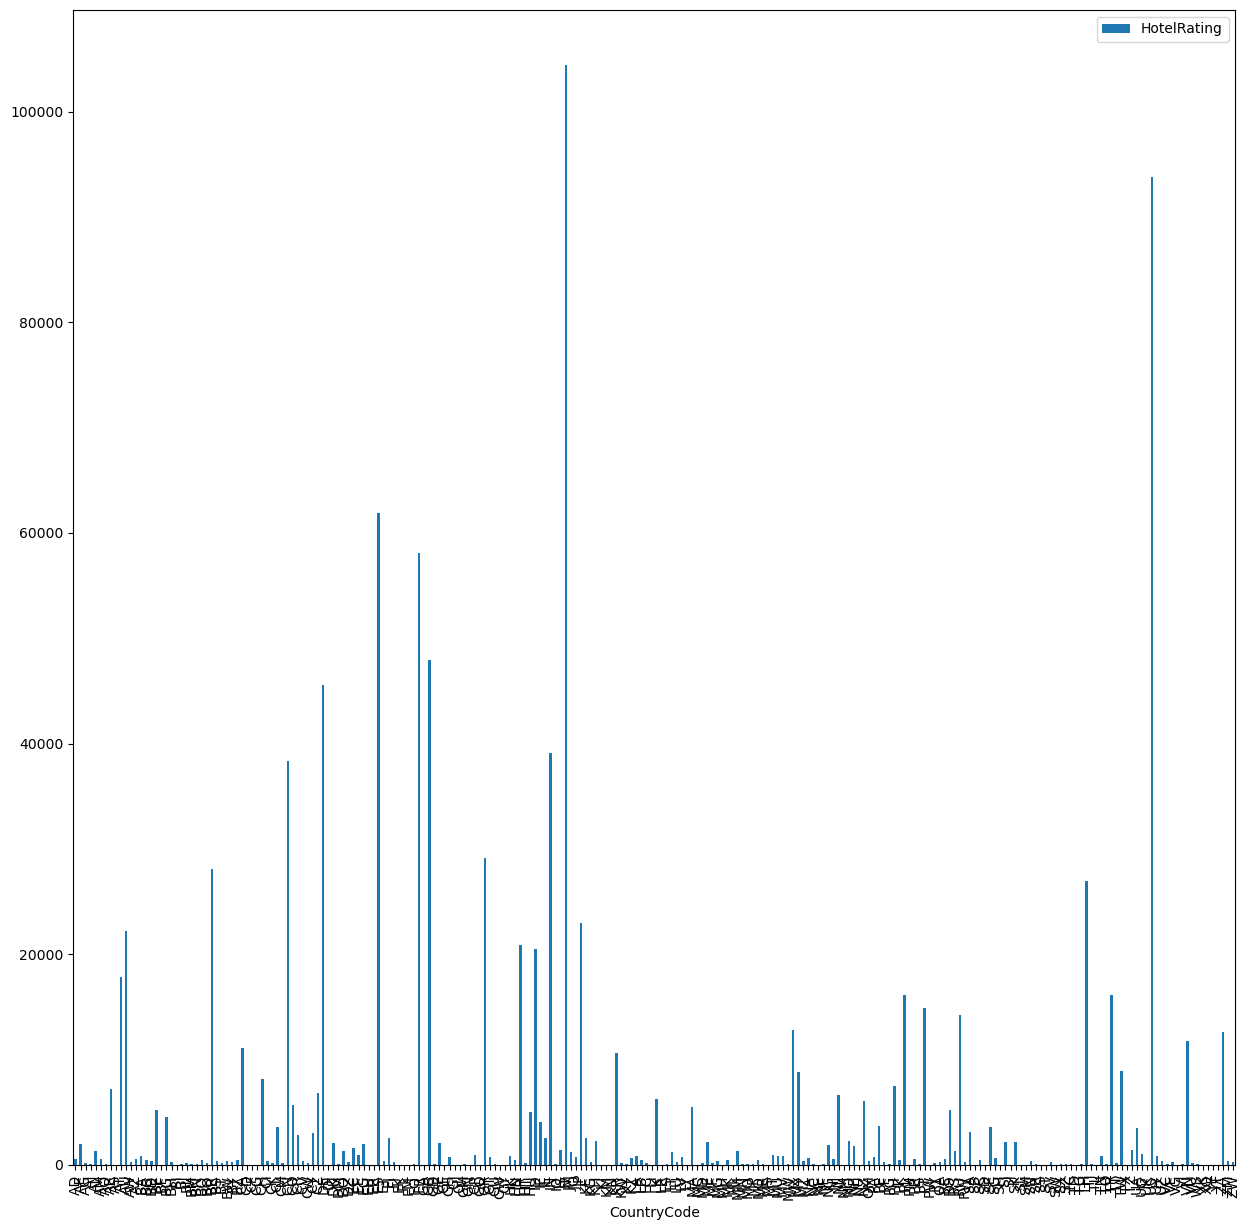

In [39]:
# Desplegando una gráfica de barra de la tabla de pivoteo
pivot_table.plot(kind='bar',figsize=(15,15))

<Axes: xlabel='CountryCode'>

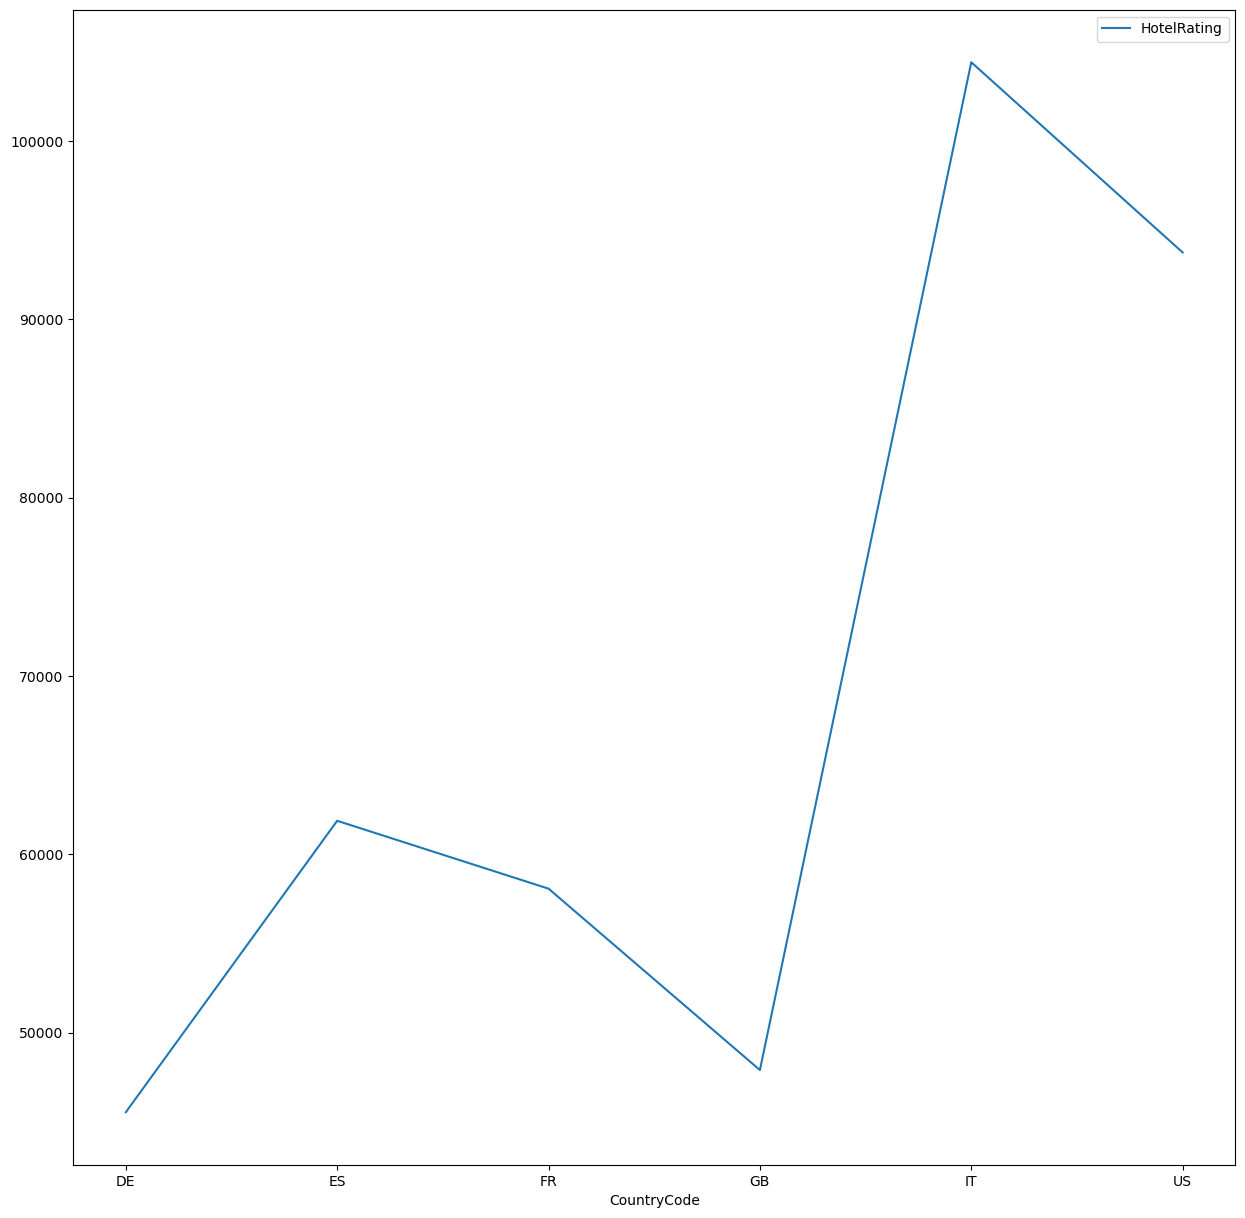

In [40]:
pivot_table.loc[pivot_table['HotelRating']>40000].plot(kind='line',figsize=(15,15))

In [41]:
# Creando un conjunto de datos para analisis de la distribucion de los datos
dataframe_analysis_dist = dataframe.drop(['HotelCode','HotelName','Description','Address','Longitude','Latitude', 'CityName'], axis=1)


array([[<Axes: title={'center': 'HotelRating'}>,
        <Axes: title={'center': 'DescLength'}>]], dtype=object)

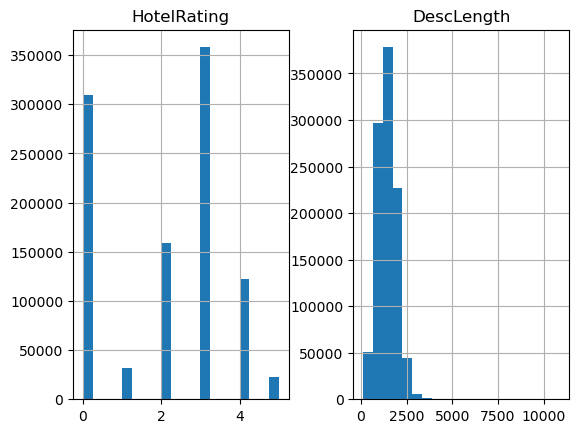

In [42]:
# Desplegando los histogramas de nivel de estrellas y el tamaño de la descripción
dataframe_analysis_dist.hist(bins=20)

In [43]:
dataframe_analysis = dataframe.loc[dataframe['DescLength']>5000]

In [44]:
# Creando una tabla de pivoteo para verificar la distribución de hoteles por país
pivot_table = pd.pivot_table(data=dataframe,index=['CountryCode'],values=['HotelRating'],aggfunc='count')

In [45]:
dataframe_analysis.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 30 entries, 22455 to 1085492
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   HotelCode    30 non-null     object 
 1   HotelName    30 non-null     object 
 2   Description  30 non-null     object 
 3   Address      30 non-null     object 
 4   Pincode      30 non-null     object 
 5   CountryCode  30 non-null     object 
 6   PhoneNumber  30 non-null     object 
 7   CityName     30 non-null     object 
 8   Longitude    30 non-null     float64
 9   Latitude     30 non-null     float64
 10  HotelRating  30 non-null     float64
 11  DescLength   30 non-null     int64  
 12  DescType     30 non-null     object 
dtypes: float64(3), int64(1), object(9)
memory usage: 3.3+ KB



Las gráficas anteriores no muestran un impacto significativo en relación a la distribución de los datos observada en el análisis exploratorio.

## **Generación de Archivos de Datos para AWS Bedrock**



Para crear la base de conocimiento, o knowledge base, usando un tamaño de pedazo a la medida, o custom chunk size, es necesario generar dos archivos por cada hotel en conjunto de datos. Un archivo tipo texto contiene la descripción del hotel y el otro archivo contiene los metadatos para el hotel (AWS, s.f.)

In [52]:
subi = 0
for row in dataframe.itertuples():
    hotel_code = row.HotelCode
    hotel_desc = row.Description

    file_name_base = hotel_code + '-' + uuid.uuid1().hex
    file_name_desc = DATA_SOURCE + '/' + file_name_base + '.txt'
    file_name_meta = file_name_desc + '.metadata.json'

    metadata = {
        'HotelCode' : hotel_code,
        'HotelName' : row.HotelName,
        'CityName' : row.CityName,
        'CountryCode': row.CountryCode,
        'HotelRating': row.HotelRating
    }
    
    json_object = json.dumps(metadata, indent=2)
    
    with open(file_name_desc, "w") as textfile:
        textfile.write(hotel_desc)
    
    with open(file_name_meta, "w") as textfile:
        textfile.write(json_object)

    # Esto se puede quitar para generar todos los archivos
    subi += 1
    if subi > 10:
        break;


## **Conclusiones**



‌El objetivo de la base de conocimiento en *Retrieval Augmented Generation*, o *RAG*, es proveer una fuente de información para proveer contexto adicional al modelo generativo, o *LLM* para que pueda generar una mejor respuesta. La calidad de la respuesta dependerá del modelo LLM usado y de la calidad del contenido en la base de conocimiento.

En AWS Bedrock una base de conocimiento se construye usando archivos de texto conteniendo la información de contexto y sus respectivos archivos de metadatos asociados (AWS, s.f.).

Para este proyecto ya se contaba con una base de datos de hoteles que contiene una descripción del hotel que puede incluir amenidades del hotel, guías para check-in y check-out, y/o una lista de atracciones y sitios de interés cercanos. La base de datos también incluye otra información del hotel como el nombre del hotel, la ciudad y el país donde se localiza y el nivel de estrellas.

Crear el archivo con la descripción del hotel con su archivo asociado con metadatos es por lo tanto la única actividad de la etapa de ingeniería de características. 


## **Referencias**

* AWS. (s.f.). Set up a data source for your knowledge base - Amazon Bedrock. docs.aws.amazon.com. Recuperado 7 de mayo, 2024, de https://docs.aws.amazon.com/bedrock/latest/userguide/knowledge-base-ds.html

* ISO. (s.f.) ISO 3166 — Country Codes. Internation Standards Organization. Recuperado 3 de mayo, 2024 de https://www.iso.org/iso-3166-country-codes.html

